In [1]:
import requests
from datetime import timezone, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [130]:
# we want to get a day's worth of crypto data from coingecko at a specified interval

CURRENCY = 'eth'

# use pre-acquired coin id data
ids = pd.read_csv("cg_coin_ids.csv")
coin_id = ids[ids['symbol'] == CURRENCY]['id'].values[0]

res = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days=1')
res.raise_for_status()

coin_data = res.json()
unzipped = list(zip(*coin_data['prices']))
prices_raw = pd.DataFrame({'ms_datetime': unzipped[0], 'price': unzipped[1]})

In [131]:
def generate_series(x):
    mask = x['ep_raw'] == True
    return pd.Series(range(1, mask.sum() + 1), index=x.index[mask])

In [140]:
ma_period = 3
ma_rsi_period = 3
rsi_periods = 14
rsi_thresh = 35

# format dataset time
prices_raw['date_time'] = pd.to_datetime(prices_raw['ms_datetime'], unit='ms', utc=True)
prices = prices_raw[['date_time', 'price']].copy()
prices['local_dt'] = prices['date_time'].dt.tz_convert(timezone(-timedelta(hours=6)))
prices = prices.sort_values(by='local_dt')[['local_dt', 'price']]

# cut down to 15-minute intervals
prices['fifteen_min'] = np.tile(range(1, 4), prices.shape[0]//3 + 1)[:prices.shape[0]]
prices['fifteen_min'] = prices['fifteen_min'] == 1
m15 = prices[prices['fifteen_min']].reset_index(drop=True)
m15 = m15[['local_dt', 'price']]

# add moving average

m15['ma'] = m15['price'].rolling(ma_period).mean()

# add rsi

m15['price_change'] = m15['price'].diff()
m15['pos_pc'] = m15['price_change'].apply(lambda x: x if x > 0 else 0)
m15['neg_pc'] = m15['price_change'].apply(lambda x: abs(x) if x < 0 else 0)

m15['avg_gain'] = m15['pos_pc'].rolling(rsi_periods).mean()
m15['avg_loss'] = m15['neg_pc'].rolling(rsi_periods).mean()
m15['rs'] = m15['avg_gain'] / m15['avg_loss']
m15['rsi'] = 100 - (100 / (1 + m15['rs']))
m15['ma_rsi'] = m15['rsi'].rolling(ma_rsi_period).mean()

# find low rsi thresholds
m15['ep_raw'] = m15['ma_rsi'] <= rsi_thresh
m15['ep_group_id'] = (m15['ep_raw'] != m15['ep_raw'].shift()).cumsum()
m15['ep_row'] = pd.concat([generate_series(group) for _, group in m15.groupby('ep_group_id')])
m15['ep'] = m15['ep_row'] == 1.0
m15['ep_price'] = m15.apply(lambda x: x['price'] if x['ep'] else np.nan, axis=1)

# drop cols
m15 = m15.drop(columns=['price_change', 'pos_pc', 'neg_pc', 'avg_gain', 'avg_loss', 'rs'])

/var/folders/pk/ts0p7qpx0ql3_tm7lltsfqlh0000gn/T/ipykernel_12509/3166266129.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(range(1, mask.sum() + 1), index=x.index[mask])


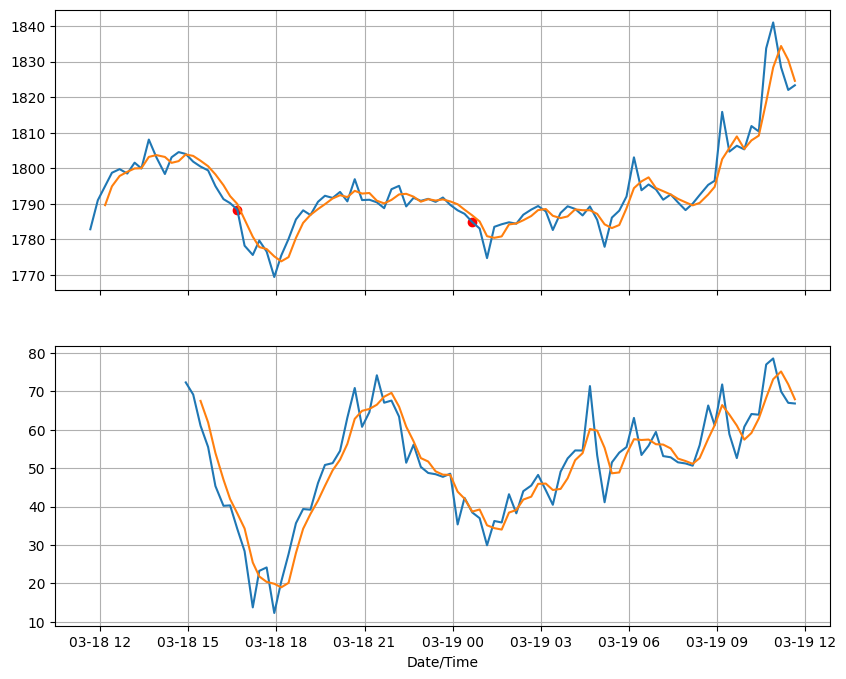

In [139]:
# plot price, moving average and rsi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


ax1.plot(m15['local_dt'], m15['price'])
ax1.plot(m15['local_dt'], m15['ma'])
ax1.scatter(m15['local_dt'], m15['ep_price'], color='red')
ax1.grid(True)

ax2.plot(m15['local_dt'], m15['rsi'])
ax2.plot(m15['local_dt'], m15['ma_rsi'])
ax2.grid(True)
ax2.set_xlabel('Date/Time')

plt.show()